# Intro..
This project delves into a comprehensive analysis of a marketing campaign, using Python libraries and statistical techniques to assess its success and uncover valuable insights. We explore critical questions like:

   - **Campaign Performance**: Was the campaign effective? We delve into key metrics like conversion and retention rates to determine its overall success.
   - **Target Audience**: Which demographics responded best? We analyze conversion rates across different age groups to identify the most receptive audience.
   - **Marketing Channel Performance**: Which channels drove the most conversions? Our analysis helps optimize future campaigns by pinpointing the most effective channels.
   - **Day-of-Week Trends**: Are there peak subscription or cancellation days? This analysis aids in optimizing campaign scheduling based on user behavior patterns.
   - **Language Targeting**: Which language delivered the highest conversion rate? We gather insights to guide future language selection for targeted campaigns.
   - **A/B Testing Impact**: Did a specific change significantly impact campaign performance? We use statistical tests to assess the effectiveness of the implemented change.

By tackling these key questions, we aim to provide valuable insights for improving future campaigns and maximizing their effectiveness.

### **1. Importing dataset**

In [2]:
# import neccesray packages
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
# import marketing file as a dataframe
marketing= pd.read_csv("marketing.csv")

# Show first 5 rows in datagrame
marketing.sample(5)

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group,date_subscribed,date_canceled,subscribing_channel,is_retained
5142,a100003299,1/31/18,Facebook,control,False,English,English,24-30 years,NaN,NaN,NaN,NaN
2116,a100000434,1/29/18,House Ads,control,False,English,English,45-55 years,NaN,NaN,NaN,NaN
1782,a100001365,1/3/18,Instagram,control,False,English,English,24-30 years,1/31/18,4/23/18,Instagram,False
5465,a100003608,1/14/18,Facebook,control,False,English,English,55+ years,NaN,NaN,NaN,NaN
3937,a100002276,1/22/18,Facebook,control,False,English,English,19-24 years,NaN,NaN,NaN,NaN


In [4]:
# Show features dataframe information
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10037 entries, 0 to 10036
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   user_id              10037 non-null  object
 1   date_served          10021 non-null  object
 2   marketing_channel    10022 non-null  object
 3   variant              10037 non-null  object
 4   converted            10022 non-null  object
 5   language_displayed   10037 non-null  object
 6   language_preferred   10037 non-null  object
 7   age_group            10037 non-null  object
 8   date_subscribed      1856 non-null   object
 9   date_canceled        577 non-null    object
 10  subscribing_channel  1856 non-null   object
 11  is_retained          1856 non-null   object
dtypes: object(12)
memory usage: 941.1+ KB


- The DataFrame has 10,037 rows and 12 features.
- All features have missing values except for the following 5: user_id, variant, language_displayed, language_preferred, and age_group.

### 2. Cleaning data

In [5]:
# Check number of nulls in each features
marketing.isna().sum()

user_id                   0
date_served              16
marketing_channel        15
variant                   0
converted                15
language_displayed        0
language_preferred        0
age_group                 0
date_subscribed        8181
date_canceled          9460
subscribing_channel    8181
is_retained            8181
dtype: int64

- Null values in the 'converted' and 'is_retained' features indicate that the user did not subscribe. Similarly, null values in 'subscribing_channel' also represent non-subscribers. Therefore, we will fill nulls with False in 'converted' and 'is_retained', and with None in 'subscribing_channel'.
- Missing values in the datetime features (date_served, etc.) also signify that the user did not subscribe.
- We will drop rows with null values in 'date_served' and 'marketing_channel'. These constitute only 16 rows, and we are not confident in imputing values for 'date_served'.

In [6]:
# fill missing values
marketing['converted']= marketing['converted'].fillna(False)

marketing['is_retained']= marketing['is_retained'].fillna(False)

marketing.loc[marketing['converted']== True, 'subscribing_channel']= marketing['subscribing_channel'].fillna('Email')
marketing['subscribing_channel']= marketing['subscribing_channel'].fillna("None")

marketing.dropna(subset=['date_served'], inplace= True)

In [7]:
# Show the number of missing values after preprocessing
marketing.isna().sum()

user_id                   0
date_served               0
marketing_channel         0
variant                   0
converted                 0
language_displayed        0
language_preferred        0
age_group                 0
date_subscribed        8165
date_canceled          9444
subscribing_channel       0
is_retained               0
dtype: int64

In [8]:
# Check duplicates in the data
print("- Number of duplicates before: ",marketing.duplicated().sum())

# drop duplicates
marketing.drop_duplicates(inplace= True)

# Check duplicates in the data
print("- Number of duplicates after dropping: ",marketing.duplicated().sum())

- Number of duplicates before:  37
- Number of duplicates after dropping:  0


In [9]:
# Convert feature types to the right type.
for col in ["date_served", "date_subscribed", "date_canceled"]:
    marketing[col]= pd.to_datetime(marketing[col])

In [10]:
# check feature types
marketing.dtypes

user_id                        object
date_served            datetime64[ns]
marketing_channel              object
variant                        object
converted                        bool
language_displayed             object
language_preferred             object
age_group                      object
date_subscribed        datetime64[ns]
date_canceled          datetime64[ns]
subscribing_channel            object
is_retained                      bool
dtype: object

### 3. Exploring data and Generate new features

In [11]:
# create DOW features which contain the day of the week the user subscribed and canceled
marketing['DOW_subscribe']= marketing['date_subscribed'].dt.dayofweek
marketing['DOW_cancel']= marketing['date_canceled'].dt.dayofweek

# Create a is_correct_lang feature to check if the user has watched the ads with the correct language or not
marketing['is_correct_lang']= np.where(marketing['language_displayed']== marketing['language_preferred'], True, False)

In [12]:
# Show features summary descriptive
marketing.describe(include=['category', 'bool'])

,converted,is_retained,is_correct_lang
count,9984,9984,9984
unique,2,2,2
top,False,False,True
freq,8910,8714,9466


In [13]:
# show the oldest and newest date in datetime features
marketing[["date_served", "date_subscribed", "date_canceled"]].agg(['min', 'max'])

,date_served,date_subscribed,date_canceled
min,2018-01-01,2018-01-01,2018-01-05
max,2018-01-31,2018-01-31,2018-05-09


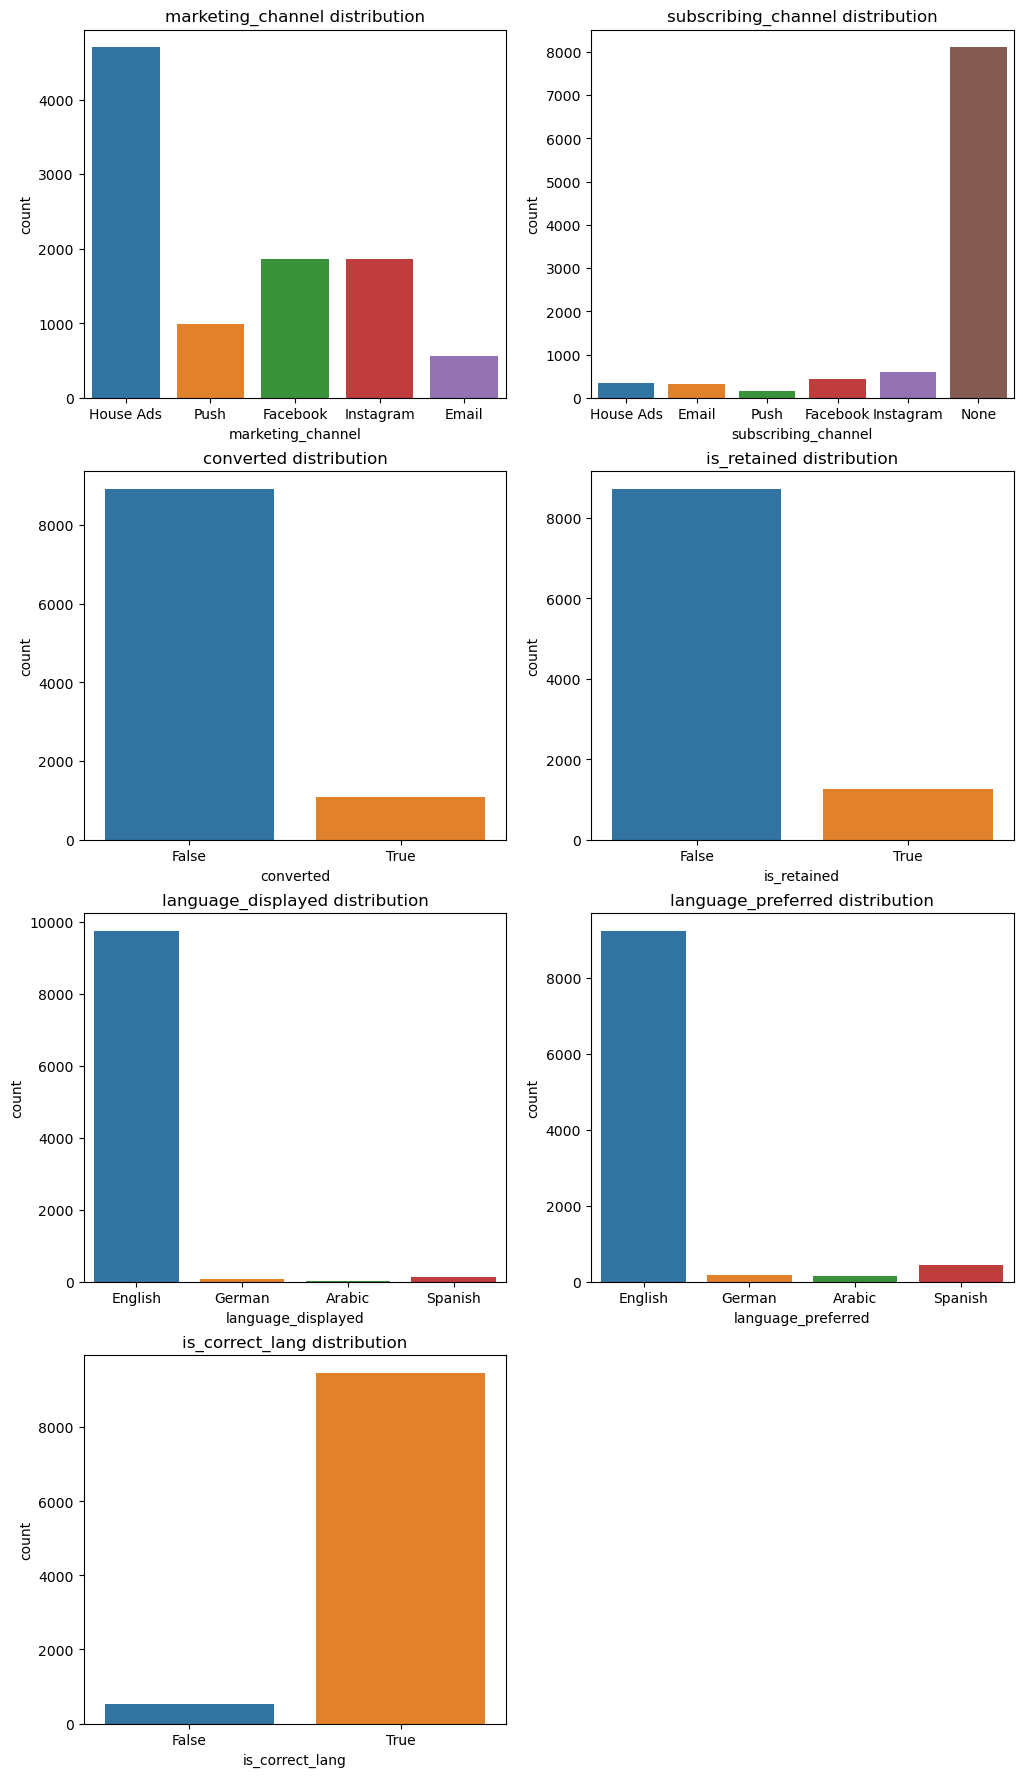

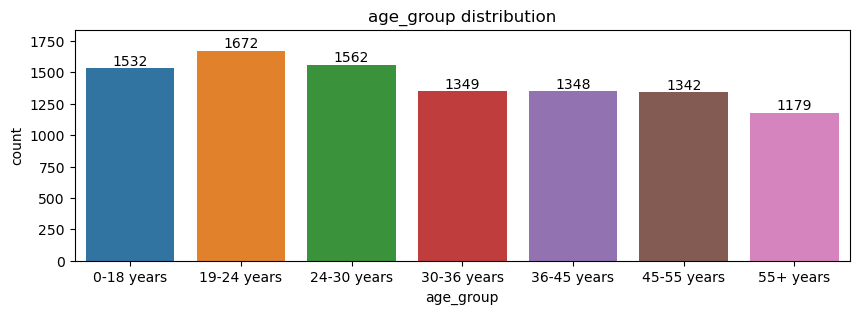

In [14]:
# visualize distributions in categorical features
plt.figure(figsize= (12, 22))

for i, col in enumerate(['marketing_channel', 'subscribing_channel', 'converted', 'is_retained', 
           'language_displayed', 'language_preferred', "is_correct_lang"], 1):
   plt.subplot(4, 2, i)
   # Plot feature categories
   g1= sns.countplot(data= marketing, x= col)
   plt.title(f"{col} distribution")
plt.show()

# Plot age group distributions\
plt.figure(figsize= (10, 3))
g= sns.countplot(data= marketing, x= 'age_group')
# set a title
plt.title("age_group distribution")
# Show bar labels
for c in g.containers:
   g.bar_label(c)
   g.margins(y= 0.1)

#### Alert ::::>
   Some ads show in other users' language, which is a big issue we need to check deeply.

Text(0.5, 1.0, 'Number of subscriptions canceled across days of week')

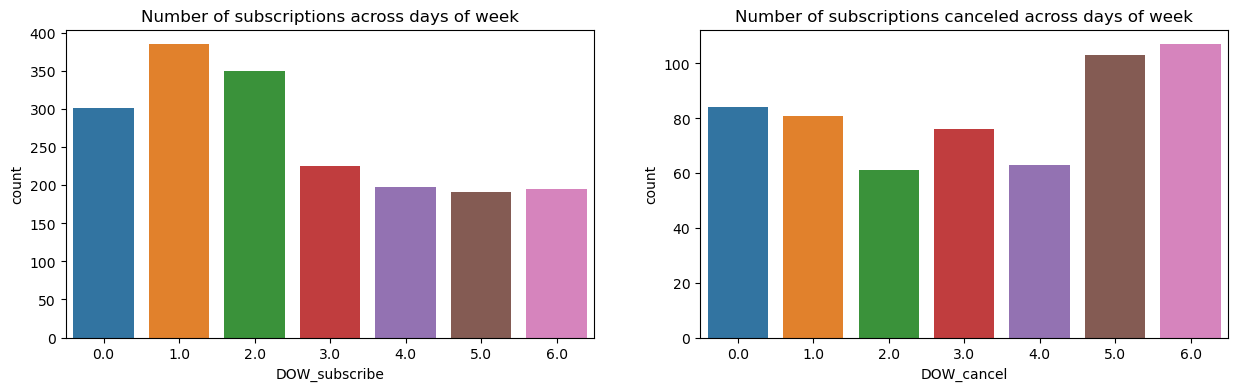

In [15]:
# Plot the number of subscription cancellations across all weekdays 
fig, ax= plt.subplots(1, 2, figsize= (15, 4))

sns.countplot(data= marketing, x='DOW_subscribe', ax= ax[0])
ax[0].set_title("Number of subscriptions across days of week")

sns.countplot(data= marketing, x='DOW_cancel', ax= ax[1])
ax[1].set_title("Number of subscriptions canceled across days of week")

- Over 55% of subscriptions occur at the beginning of the week, while cancellations peak towards the end, as shown in the previous charts.

# 4. Analyzing data and get insights 

### 4.1 Create useful functions

In [16]:
def conversion_rate(df, col, fill_value=0):
    """
    Calculates the conversion rate for each group in a given column.
    Args:
      df (pd.DataFrame): The DataFrame containing the data.
      col (str): The column name to group by.
      fill_value (float, optional): The value to fill missing conversion rates. Defaults to 0.
    Returns:
      pd.Series: A Series containing the conversion rate for each group.
    """
    # Count total users and converted users for each group efficiently
    total_users = df.groupby(col)['user_id'].nunique()
    converted_users = df[df['converted'] == True].groupby(col)['user_id'].nunique()
    # Calculate conversion rate and handle missing values
    conversion_rate = converted_users / total_users
    conversion_rate = conversion_rate.fillna(fill_value)

    return conversion_rate

In [17]:
# create a function to compute retention rate
def retention_rate(df, col):
    """
        Computes retention rate for a DataFrame based on a grouping column.
    Args:
        df (pd.DataFrame): The DataFrame containing user data.
        col (str): The column to group users by.
    Returns:
        pd.DataFrame: A DataFrame with retention rates for each group.
    """
    # Count converted and retained users efficiently using value_counts
    subscribers = df[df['converted'] == True][col].value_counts()
    retained = df[df['is_retained'] == True][col].value_counts()

    retention_rate= pd.DataFrame(np.round(retained / subscribers *100, 2))

    return retention_rate

In [18]:
def conv_retention_rate(df, col):
    """
    Computes and visualizes conversion and retention rates across categories of a specified column.
    Args:
        df (pd.DataFrame): The DataFrame containing user data.
        col (str): The column to group by and calculate rates for.
    Returns:
        pd.DataFrame: A styled DataFrame with conversion and retention rates for each category.
    """
    # Calculate total, converted, and retained users efficiently
    total_users = df.groupby(col)['user_id'].nunique()
    converted_users = df[df['converted'] == True].groupby(col)['user_id'].nunique()
    retained_users = df[df['is_retained'] == True].groupby(col)['user_id'].nunique()
    # Combine rates into a single DataFrame and format
    rates_df = pd.DataFrame({
        'conversion_rate': converted_users / total_users,
        'retention_rate': retained_users / converted_users
    })
    
    rates_df = rates_df.style.background_gradient(cmap="Greens").format('{:.2%}')
    print(f"- Conversion and retention rates across {col} categories:\n")
    
    return rates_df

In [19]:
def plot_conv(df, col, kind='line'):
    """
        Plots the daily conversion rate for different categories of a given feature.
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        col (str): The name of the feature to be analyzed.
        kind (str, optional): The type of plot to create. Defaults to 'line'.
    """
    # Calculate the total number of users per category
    total_users = df.groupby(col)['user_id'].nunique()
    # Calculate the number of converted users per category
    converted_users = df[df['converted'] == True].groupby(col)['user_id'].nunique()
    # Calculate the conversion rate for each category
    conversion_rate = converted_users / total_users * 100  # Convert to percentage
    # Create a DataFrame for plotting
    conversion_df = pd.DataFrame(conversion_rate.unstack(level=1))
    # Create the plot
    conversion_df.plot(figsize=(10, 3), kind=kind, xlabel=col[0], ylabel='Conversion Rate (%)')
    # Set plot title and legend
    plt.title(f'Conversion Rate by {col[1]} Categories', size=14)
    plt.legend(labels=conversion_df.columns.values, loc='upper right')
    # Display the plot
    plt.show()

### 4.2 daily reach and subscriptions..

Text(0, 0.5, 'Number of users')

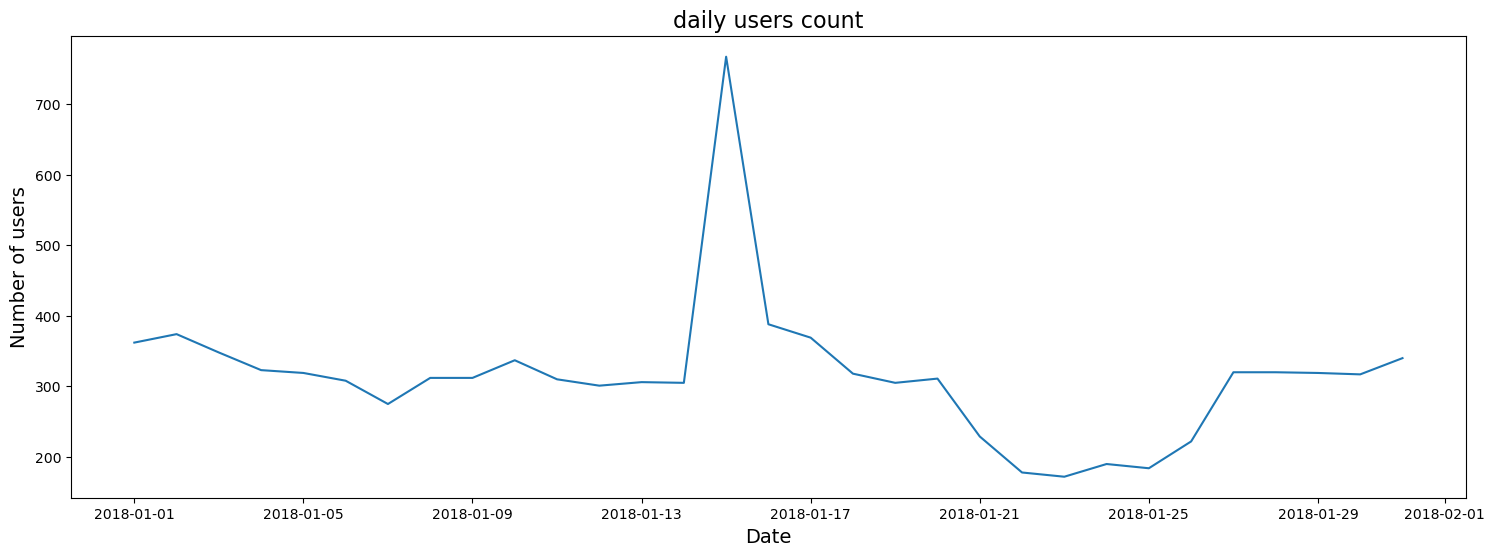

In [20]:
# Compute daily user reach count
daily_users= marketing.groupby('date_served').agg(users_num= ("user_id", "nunique"))

# Show first rows in daily_users
# display(daily_users.head())

# Plot daily_users count and set a title, x and y labels
plt.figure(figsize= (18, 6))
plt.plot(daily_users)
plt.title("daily users count", fontsize= 16)
plt.xlabel("Date", fontsize=14) ; plt.ylabel("Number of users", fontsize=14)

<AxesSubplot:title={'center':'Daily conversion rate'}, xlabel='Date', ylabel='Conversion rate%'>

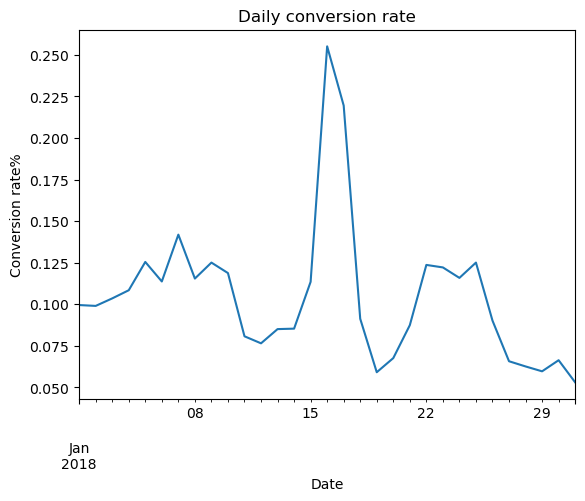

In [21]:
# Compute daily conversion
daily_conv= conversion_rate(marketing, "date_served")

daily_conv.plot(title= "Daily conversion rate", xlabel= "Date", ylabel= "Conversion rate%")

### 4.3 Rate the campaign performance 
           - Compute overall conversion and retention rates.

In [22]:
## Compute overall conversion rate
# compute number of users
total= marketing['user_id'].nunique()
# compute the number of converted users
subscribers= marketing[marketing['converted']== True]['user_id'].nunique()
# compute the number of retained users
retained= marketing[marketing['is_retained']== True]['user_id'].nunique()

conv_rate= np.round(subscribers / total *100, 2)
retaintion_rate= np.round(retained / subscribers *100, 2)

print("- Conversion rate= ", conv_rate, "%")
print("- retention rate= ", retention_rate, "%")

- Conversion rate=  13.92 %
- retention rate=  <function retention_rate at 0x000001BA89340430> %


**- Was the campaign successful?** 
Determining campaign success isn't based on a single metric, but requires comparing our results to historical performance of similar industry campaigns. 

###### Let's delve into conversion and retention rates, along with other key metrics, to understand the campaign's impact across different features...

### 4.4 Compute and visualize conversion rate across features categories..

In [23]:
# Show conversion and retention rates by groups
for col in ["age_group", 'marketing_channel', ["age_group", 'marketing_channel'], 
           'language_displayed', 'language_preferred']:
    df= conv_retention_rate(marketing, col)
    display(df)

- Conversion and retention rates across age_group categories:



,conversion_rate,retention_rate
age_group,,
0-18 years,15.92%,87.50%
19-24 years,23.24%,78.55%
24-30 years,18.72%,87.72%
30-36 years,7.28%,112.99%
36-45 years,7.01%,113.51%
45-55 years,7.10%,112.00%
55+ years,7.76%,71.05%


- Conversion and retention rates across marketing_channel categories:



,conversion_rate,retention_rate
marketing_channel,,
Email,33.82%,74.33%
Facebook,12.57%,95.48%
House Ads,7.51%,126.85%
Instagram,13.33%,85.34%
Push,7.92%,123.38%


- Conversion and retention rates across ['age_group', 'marketing_channel'] categories:



- Conversion and retention rates across language_displayed categories:



,conversion_rate,retention_rate
language_displayed,,
Arabic,50.00%,75.00%
English,12.94%,66.85%
German,71.62%,77.36%
Spanish,20.00%,100.00%


- Conversion and retention rates across language_preferred categories:



,conversion_rate,retention_rate
language_preferred,,
Arabic,17.92%,63.16%
English,13.28%,67.26%
German,45.04%,72.88%
Spanish,11.08%,119.44%


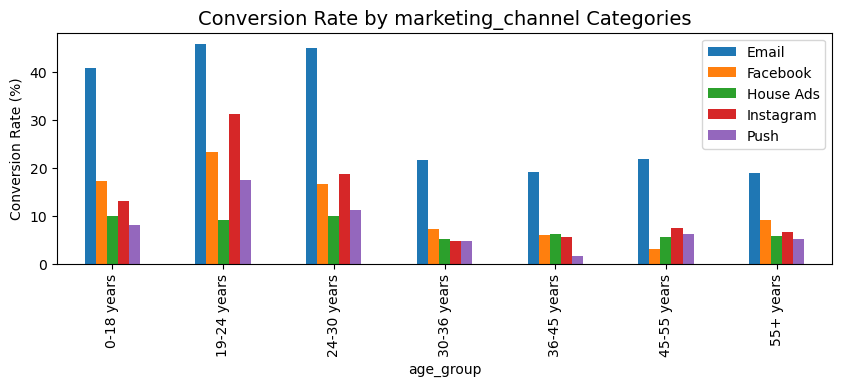

In [24]:
# Visulaize conversion rate by Marketing channels and age groups
plot_conv(marketing, ["age_group", 'marketing_channel'], 'bar')

## - Identifying language displayed bug
Calculating the percentage of users served incorrect ad languages and visualizing the results.

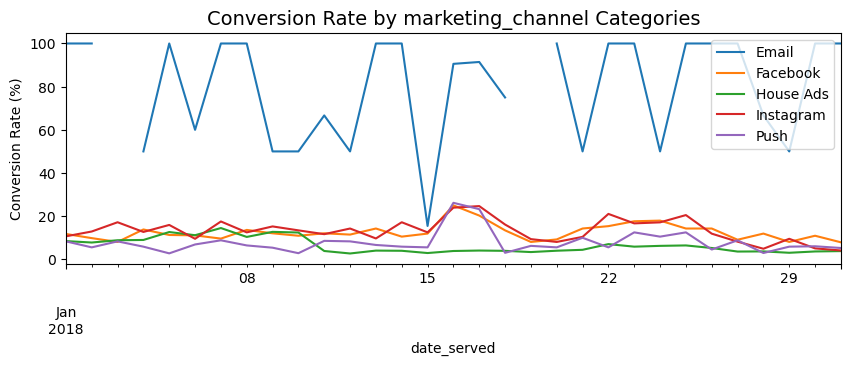

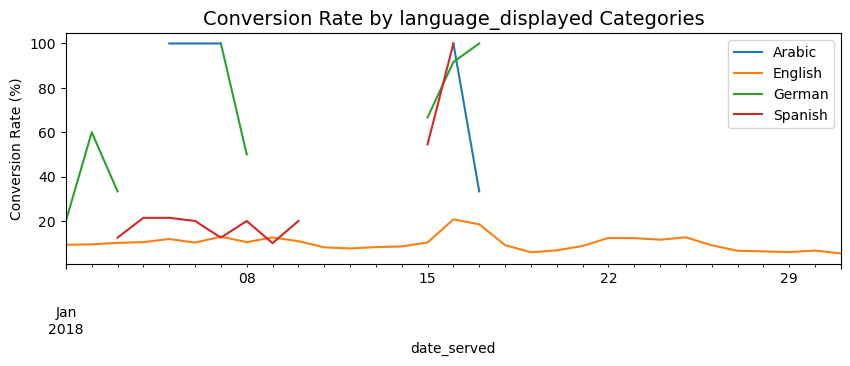

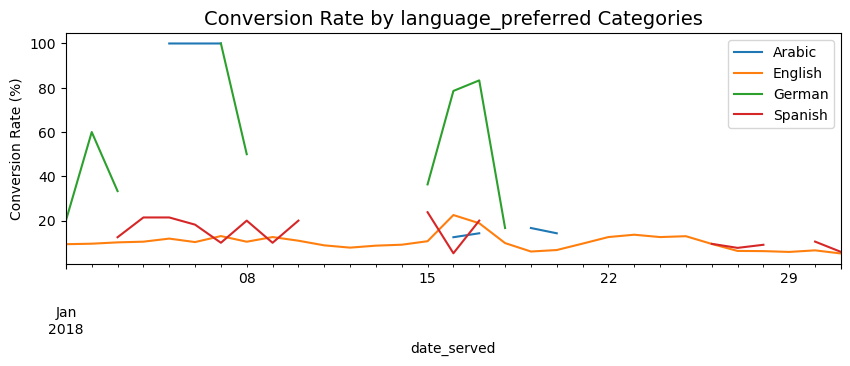

In [25]:
# Visualize conversion rate across days by features categories
for col in ['marketing_channel', 'language_displayed', 'language_preferred']:
    plot_conv(marketing, ['date_served', col])

Text(0.5, 1.0, 'Average Corrected User Language Appearance')

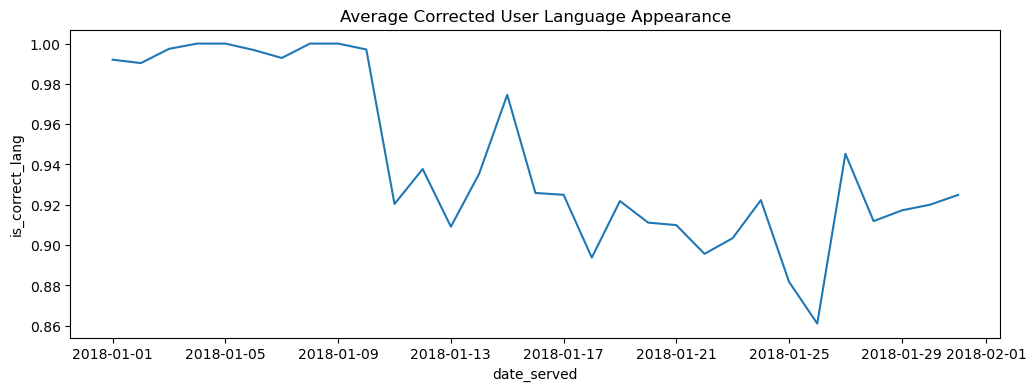

In [26]:
# Visualize the average daily corrected user language
plt.figure(figsize=(12, 4))
sns.lineplot(data= marketing, x= 'date_served', y= "is_correct_lang", ci= None)
plt.title("Average Corrected User Language Appearance")

- In the previous plot, following the data points reveals that the issue of displaying the wrong language began to increase on "2018-01-11", and continued until the end of the observed period. Consequently, we will isolate the corrected portion of the dataset.
- Examining the daily conversion rate by 'language_displayed' and 'language_preferred' in the figure above, we observe that only English exhibits a normal distribution across all days. For this reason, we will use English as a baseline for comparison with other languages.
- The "Conversion Rate by Marketing Channels" plot reveals that House Ads is the channel most affected by this bug.

In [27]:
# Create dataframes for House Ads and pre-error data to calculate conversion rates
house_ads = marketing[marketing['marketing_channel'] == 'House Ads']
house_ads_No_bug = house_ads[house_ads['date_served'] < '2018-01-11']
lang_conv = conversion_rate(house_ads_No_bug, ['language_displayed'])

# Calculate language conversion rate indices against English
spanish_index = lang_conv['Spanish'] / lang_conv['English']
arabic_index = lang_conv['Arabic'] / lang_conv['English']
german_index = lang_conv['German'] / lang_conv['English']

# Print results with explanations
print("Conversion rates (percentage):")
print(lang_conv * 100)
# These indices help evaluate how well our marketing assets typically convert users for each language compared to English.
print("\nLanguage conversion rate indices against English:")
print("Spanish index:", spanish_index)
print("Arabic index:", arabic_index)
print("German index:", german_index)

Conversion rates (percentage):
language_displayed
Arabic     50.000000
English     9.909281
German     44.444444
Spanish    16.666667
Name: user_id, dtype: float64

Language conversion rate indices against English:
Spanish index: 1.681924882629108
Arabic index: 5.045774647887324
German index: 4.485133020344287


- Having created language-specific indexes compared to English, we can now evaluate expected conversion rates for the rest of the month.

In [28]:
# Create a dataframe with daily conversion data, including user reach and converted users across days
converted = house_ads.groupby(['date_served', 
                          'language_preferred']).agg({'user_id':'nunique','converted':'sum'})
# Unstack converted
converted = pd.DataFrame(converted.unstack(level=1))
display(converted.head())

user_id                        converted                 \
language_preferred  Arabic English German Spanish    Arabic English German   
date_served                                                                  
2018-01-01             2.0   171.0    5.0    11.0       2.0    13.0    1.0   
2018-01-02             3.0   200.0    5.0    10.0       0.0    14.0    3.0   
2018-01-03             2.0   179.0    3.0     8.0       0.0    15.0    1.0   
2018-01-04             2.0   149.0    2.0    14.0       0.0    12.0    0.0   
2018-01-05             NaN   143.0    1.0    14.0       NaN    17.0    0.0   

                            
language_preferred Spanish  
date_served                 
2018-01-01             0.0  
2018-01-02             0.0  
2018-01-03             1.0  
2018-01-04             3.0  
2018-01-05             3.0

In [29]:
# Create English conversion rate column for affected period
converted = converted.loc['2018-01-11':'2018-01-31']
converted['english_conv_rate'] = converted[('converted','English')]

# Create expected conversion rates for each language
converted['expected_spanish_rate'] = converted['english_conv_rate']*spanish_index
converted['expected_arabic_rate'] = converted['english_conv_rate']*arabic_index
converted['expected_german_rate'] = converted['english_conv_rate']*german_index

# Multiply number of users by the expected conversion rate to get expected subscribers
converted['expected_spanish_conv'] = converted['expected_spanish_rate']/100\
                                    *converted[('user_id','Spanish')]
converted['expected_arabic_conv'] = converted['expected_arabic_rate']/100\
                                    *converted[('user_id','Arabic')]
converted['expected_german_conv'] = converted['expected_german_rate']/100\
                                    *converted[('user_id','German')]
# # Determining the number of lost subscribers
# Calculate the total expected subscribers
expected_subs = converted['expected_spanish_conv'].sum() + \
                converted['expected_arabic_conv'].sum() + \
                converted['expected_german_conv'].sum()

# Calculate the actual subscribers
actual_subs = converted['converted', 'Spanish'].sum() + \
            converted['converted', 'Arabic'].sum() + \
            converted['converted', 'German'].sum()

# Calculate the number of lost subscribers due to the bug
lost_subs = expected_subs - actual_subs
print("- The difference between expectad and actual subscribers= ", int(lost_subs))

- The difference between expectad and actual subscribers=  32


## - Personalization A/B Test

In [30]:
def lift(a, b):
    """Calculates the lift metric between two arrays a and b.
    Args:
        a (array-like): The first array of values.
        b (array-like): The second array of values.
    Returns:
        str: The calculated lift as a percentage, rounded to two decimal places.
    """
    # Calculate the means of a and b
    a_mean = np.mean(a)
    b_mean = np.mean(b)
    # Calculate the lift using a_mean and b_mean
    lift = (b_mean - a_mean) / a_mean
    # Format and return the lift percentage
    return(f"{lift * 100:.2f}%")

In [31]:
# Create an A/B segmentation function for calculating lift and T-test
def ab_segmentation(segment):
    """
    Calculates lift and T-test statistics for A/B test segmentation.
    Args:
        segment (str): The name of the segment to analyze.
    """
    # Iterate through unique values of the specified segment
    for subsegment in np.unique(marketing[segment]):
        print(subsegment)
        # Subset marketing data to email channel and current subsegment
        email = marketing[(marketing['marketing_channel'] == 'Email') & (marketing[segment] == subsegment)]
        # Group subscribers by user ID and variant, keeping maximum conversion per user
        subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
        subscribers = pd.DataFrame(subscribers.unstack(level=1))  # Convert Series to DataFrame
        
        # Handle null values and convert to float for T-test
        control = subscribers['control'].dropna().astype('float')
        personalization = subscribers['personalization'].dropna().astype('float')
        # Print lift and T-test results
        print('lift:', lift(control, personalization))
        print('t-statistic:', stats.ttest_ind(control, personalization), '\n')

#### - Test allocation

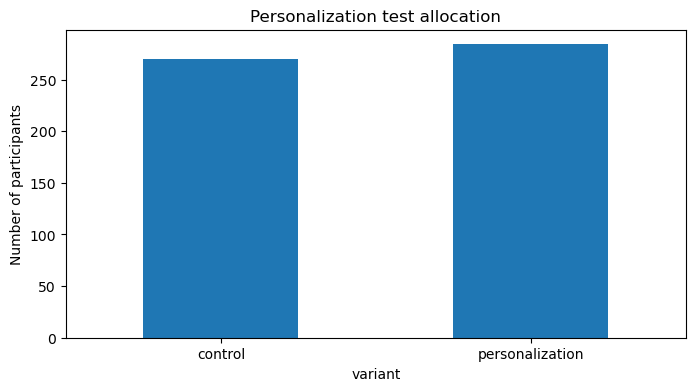

In [32]:
# Subset Email channel data in a new DataFrame
email = marketing[marketing['marketing_channel'] ==  'Email']

# Group the email DataFrame by variant 
allocation = email.groupby('variant')['user_id'].nunique()

# Plot a bar chart of the test allocation
allocation.plot(kind = 'bar', rot=0, figsize=(8,4))
plt.title('Personalization test allocation')
plt.ylabel('Number of participants')
plt.show()

### Setting up our data to evaluate the test

In [33]:
# Group by user_id and variant
subscribers = email.groupby(['user_id', 'variant'])['converted'].max()
subscribers = pd.DataFrame(subscribers.unstack(level=1)) 

# Drop missing values from the control column
control = subscribers['control'].astype('float').dropna()
# Drop missing values from the personalization column
personalization = subscribers['personalization'].astype('float').dropna()
# Calculate conversion rate to each group
print("- Control conversion rate:", f"{np.mean(control):0.2f}") 
print("- Personalization conversion rate:", f"{np.mean(personalization):0.2f}") 

- Control conversion rate: 0.28
- Personalization conversion rate: 0.39


#### Evaluating overall statistical significance

In [34]:
# Print lift() with control and personalization as inputs
print('- lift: ', lift(control, personalization))
# run T_test
stats.ttest_ind(control, personalization)

- lift:  38.85%


Ttest_indResult(statistic=-2.734329944750507, pvalue=0.006451487844694182)

- The test is statistically significant with a p-value much less than 0.05, and the Personalization group performed 39% better than the control group. This suggests that the implemented changein email message had a positive impact.

#### A/B test segmenting
Segmenting your A/B test results by key demographics is crucial for understanding the test's full impact. Remember, different customer groups may respond differently!

In [35]:
# Use ab_segmentation on age group
ab_segmentation('age_group')

0-18 years
lift: 121.40%
t-statistic: Ttest_indResult(statistic=-2.966044912142212, pvalue=0.003872449439129706) 

19-24 years
lift: 106.24%
t-statistic: Ttest_indResult(statistic=-3.0317943847866697, pvalue=0.0030623836114689195) 

24-30 years
lift: 161.19%
t-statistic: Ttest_indResult(statistic=-3.861539544326876, pvalue=0.00018743381094867337) 

30-36 years
lift: -100.00%
t-statistic: Ttest_indResult(statistic=3.185906464414798, pvalue=0.0023238487431765337) 

36-45 years
lift: -85.23%
t-statistic: Ttest_indResult(statistic=2.431790127931851, pvalue=0.017975686009788255) 

45-55 years
lift: -72.22%
t-statistic: Ttest_indResult(statistic=2.0654991273179326, pvalue=0.04306233968820123) 

55+ years
lift: -100.00%
t-statistic: Ttest_indResult(statistic=3.326565456420339, pvalue=0.0016358623456360468) 



- A/B test change significantly boosted conversions for younger age groups (0-30 years) but resulted in negative impacts on older groups (30+ years).

In [36]:
# Use ab_segmentation on languages
ab_segmentation('language_displayed')

Arabic
lift: 50.00%
t-statistic: Ttest_indResult(statistic=-0.5773502691896255, pvalue=0.5795840000000001) 

English
lift: 39.00%
t-statistic: Ttest_indResult(statistic=-2.2183598646203215, pvalue=0.026991701290720503) 

German
lift: -1.62%
t-statistic: Ttest_indResult(statistic=0.19100834180787182, pvalue=0.8494394170062678) 

Spanish
lift: 166.67%
t-statistic: Ttest_indResult(statistic=-2.3570226039551585, pvalue=0.040156718110477524) 



- The A/B test change had a statistically significant positive impact on conversions for English and Spanish , but no significant impact on Arabic and a negative impact on German.

# Conclusion..
Our analysis revealed intriguing patterns in user behavior and campaign performance. Weekday subscriptions peak early, while cancellations rise later. Younger users (0-30) convert best, but retain less compared to the 30-55 age group. Email marketing drives the highest conversions, while House Ads boast the best retention. Interestingly, younger users respond best to internet channels like Facebook and Email, while House Ads and Push are crucial for their retention. Older users heavily favor Email for conversions, with Push showing promise for specific age ranges. Language-wise, German and Arabic excel in conversions, while Spanish leads in retention.

Beyond these insights, our A/B test successfully boosted conversions by 39% in the Personalization group (p-value < 0.05), demonstrating the positive impact of the implemented email change. However, we noted an age-specific trend: the change benefitted younger users (0-30) but negatively impacted older demographics (30+). Similarly, the language A/B test showed positive effects for English and Spanish but not Arabic or German.

**Recommendations:**

- Tailor outreach by day of the week: Focus acquisition efforts early in the week, and consider retention strategies towards the end.
- Craft age-specific campaigns: Develop distinct approaches for younger and older user segments based on their preferred channels and conversion/retention patterns.
- Refine language targeting: Prioritize German and Arabic for conversion-focused campaigns, while Spanish might be more effective for retention efforts.
- Double down on personalization: Expand the successful personalization strategy to further optimize campaign performance.
- Investigate age-specific A/B test results: Explore reasons behind the differential impact on various age groups to refine future targeting.

By implementing these recommendations, we can leverage the insights from this analysis to significantly improve campaign effectiveness and user engagement across different segments.